# Predict bank customers churn

In [1]:
%matplotlib inline
import psycopg2
import pickle

# data processing
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Supervised Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, make_scorer
from sklearn.model_selection import GridSearchCV

# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Explainability
import shap

c:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Data

the dataset is available here: https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers

- CustomerId—contains random values and has no effect on customer leaving the bank.
- Surname—the surname of a customer has no impact on their decision to leave the bank.
- CreditScore—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
- Geography—a customer’s location can affect their decision to leave the bank.
- Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.
- Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
- Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
-Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
- NumOfProducts—refers to the number of products that a customer has purchased through the bank.
- HasCrCard—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
- IsActiveMember—active customers are less likely to leave the bank.
- EstimatedSalary—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
- Churn—whether or not the customer left the bank.

In [2]:
## load data from local csv 
#df = pd.read_csv(
#        filepath_or_buffer = '../data/bank_customers_churn_dataset.csv',
#        index_col='customer_id'
#)
#
## drop churn column for segmentation
#df.drop('churn', axis=1, inplace=True)
#
## change type of categorical columns "credit_card" and "active_member"
#df['credit_card'] = df['credit_card'].apply(lambda x: 'yes' if x == 1 else 'no')
#df['active_member'] = df['active_member'].apply(lambda x: 'yes' if x == 1 else 'no')
#
#df.head()

## Utility Functions

In [3]:
def get_data_from_my_postgre_db(password:str, table_name:str)->pd.DataFrame:
    """connects to marketing_analytics db and returns data from table_name as pandas dataframe .
    inputs: database password and table_name"""
    # Connect to the database
    conn = psycopg2.connect(
        database="marketing_analytics", 
        user="postgres", 
        password=password, 
        host="localhost", 
        port="5432")
    # Create a cursor object
    cur = conn.cursor()
    # Execute a SQL query
    #cur.execute("SELECT * FROM bank_customers_churn_dataset")
    cur.execute("SELECT * FROM " + table_name) 
    # Get the column names from the cursor description
    columns = [desc[0] for desc in cur.description]
    # Fetch the results i.e. values
    results = cur.fetchall()
    # Create a dictionary mapping column names to values
    data = [dict(zip(columns, row)) for row in results]
    # Close the connection
    conn.close()
    # turn dictionary into dataframe
    return pd.DataFrame.from_dict(data)

def create_missing_values(df:pd.DataFrame, na_percentage=0.05)->pd.DataFrame:
    """impute missing values in na_percentage of rows in each column"""
    X = df.copy()
    # Create an array of 5 percent of the number of rows in the dataframe
    num_rows = X.shape[0]
    num_missing_values = int(num_rows * na_percentage)

    # Iterate through each row and set the values to np.nan
    for col in X.columns:
        # Get a random sample of rows from 0 to num_rows-1
        random_indices = random.sample(X.index.to_list(), num_missing_values)
        for row in random_indices:  
            X.loc[row, col] = np.nan
    return X

def create_outliers(df:pd.DataFrame, numeric_columns:list, na_percentage=0.05)->pd.DataFrame:
    """impute outliers in na_percentage of rows in each numeric column"""
    X = df.copy()
    # Create an array of 5 percent of the number of rows in the dataframe
    num_rows = X.shape[0]
    num_outliers = int(num_rows * na_percentage)

    # Iterate through each row and set the values to np.nan
    for col in X[numeric_columns]:
        # get mean value, standard deviation and minimum
        mean, sd, min = X[col].mean(), X[col].std(), X[col].min()
        # Generate random numbers from normal distribution
        rand_norm = np.random.normal(mean, sd, 1000000)
        # Generate outliers which are at least mean+/-3*std
        if min < 0:
            outliers = np.append(rand_norm[rand_norm < mean-3*sd], rand_norm[rand_norm > mean+3*sd])
        else:
            outliers = rand_norm[rand_norm > mean+3*sd]

        # Get a random sample of rows from 0 to num_rows-1
        random_indices = random.sample(X.index.to_list(), num_outliers)
        for row in random_indices:
            X.loc[row, col] = random.sample(outliers.tolist(), 1)[0]
    return X

def plot_confusion_matrix(features:pd.DataFrame, labels:np.array, sklearn_model):
    """plot confusion matrix for trained model given labels and one-hotencoded features"""
    # calc confusion matrix
    cm = confusion_matrix(labels, sklearn_model.predict(features), labels=sklearn_model.classes_)
    # create matrix display
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,                            
        display_labels=sklearn_model.classes_)
    disp.plot()
    plt.show()

In [4]:
f = open("../private.txt", "r")
pw = f.read()

In [5]:
# get data from postres db
table_name = "bank_customers_churn_dataset"
df = get_data_from_my_postgre_db(pw, table_name)

# set customer id as index
df.set_index('customer_id', inplace=True)

## change churn column type to bool
df['churn'] = df['churn'].astype('int').astype('bool')

# change data types to numeric
df['tenure'] = df['tenure'].apply(lambda x: int(x))
df['products_number'] = df['products_number'].apply(lambda x: int(x))
df['credit_card'] = df['credit_card'].apply(lambda x: int(x))
df['active_member'] = df['active_member'].apply(lambda x: int(x))

# change type of categorical columns "credit_card" and "active_member"
df['credit_card'] = df['credit_card'].apply(lambda x: 'yes' if x == 1 else 'no')
df['active_member'] = df['active_member'].apply(lambda x: 'yes' if x == 1 else 'no')

In [6]:
df.dtypes

credit_score        float64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card          object
active_member        object
estimated_salary    float64
churn                  bool
dtype: object

In [7]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
customer_id,,,,,,,,,,,
15634602,619.0,France,Female,42,2,0.00,1,yes,yes,101348.88,True
15647311,608.0,Spain,Female,41,1,83807.86,1,no,yes,112542.58,False
15619304,502.0,France,Female,42,8,159660.80,3,yes,no,113931.57,True
15701354,699.0,France,Female,39,1,0.00,2,no,no,93826.63,False
15737888,850.0,Spain,Female,43,2,125510.82,1,yes,yes,79084.10,False


In [8]:
# check unique values for categorical values
print(df['country'].unique())
print(df['gender'].unique())
print(df['credit_card'].unique())
print(df['active_member'].unique())
print(df['churn'].unique())

['France' 'Spain' 'Germany']
['Female' 'Male']
['yes' 'no']
['yes' 'no']
[ True False]


# Train-Test Split the Data

In [9]:
df.shape

(10000, 11)

In [10]:
# divide features and target
X = df.iloc[:,:-1]
y = df['churn'].values

In [11]:
# way too much data for training; let´s split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.5, 
    stratify=y,
    random_state=123)

In [12]:
X_train.shape

(5000, 10)

In [13]:
X_test.shape

(5000, 10)

In [14]:
X_train.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
customer_id,,,,,,,,,,
15733705,577.0,France,Female,30,8,92472.10,2,no,yes,126434.61
15580719,697.0,France,Female,23,10,0.00,2,yes,yes,79734.23
15613923,581.0,Spain,Female,43,4,170172.90,1,no,yes,100236.02
15624703,550.0,Germany,Male,35,9,129847.75,2,yes,no,197325.40
15743817,621.0,Germany,Male,40,8,174126.75,3,yes,no,172490.78


## Simulate Additional Missing Values and Outliers to Ensure the Methods for Recovery Work

In [15]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = X_train.select_dtypes(include=numerics).columns.to_list()
categorical_columns = X_train.select_dtypes(exclude=numerics).columns.to_list()

print('numeric columns: {}'.format(numeric_columns))
print('categorical columns: {}'.format(categorical_columns))

numeric columns: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary']
categorical columns: ['country', 'gender', 'credit_card', 'active_member']


In [16]:
# create some more missing data in 5% of all rows to ensure enough missing data to test the missing data imputation methods
X_train = create_missing_values(X_train, na_percentage=0.05)
X_test = create_missing_values(X_test, na_percentage=0.05)

In [17]:
# create additional outliers in 5% of the rows to test out outlier removal method
X_train = create_outliers(X_train, numeric_columns, 0.05)
X_test = create_outliers(X_test, numeric_columns, 0.05)

# Exploratory Data Analysis

In [18]:
X_train

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
customer_id,,,,,,,,,,
15733705,577.000000,France,Female,30.0,8.0,92472.100000,2.000000,no,yes,126434.61
15580719,697.000000,France,Female,23.0,10.0,0.000000,2.000000,yes,yes,79734.23
15613923,581.000000,Spain,Female,43.0,4.0,302134.442224,3.301134,no,yes,100236.02
15624703,550.000000,Germany,Male,35.0,9.0,129847.750000,2.000000,yes,no,197325.40
15743817,1003.144118,Germany,Male,40.0,8.0,174126.750000,3.000000,yes,no,172490.78
...,...,...,...,...,...,...,...,...,...,...
15574879,631.000000,Germany,Female,37.0,NaN,121801.720000,2.000000,no,yes,23146.62
15815628,711.000000,France,Female,37.0,8.0,113899.920000,1.000000,no,no,80215.20
15810942,445.000000,Germany,NaN,61.0,2.0,137655.310000,1.000000,no,NaN,29909.84


In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 15733705 to 15696852
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      4765 non-null   float64
 1   country           4750 non-null   object 
 2   gender            4750 non-null   object 
 3   age               4765 non-null   float64
 4   tenure            4763 non-null   float64
 5   balance           4763 non-null   float64
 6   products_number   4770 non-null   float64
 7   credit_card       4750 non-null   object 
 8   active_member     4750 non-null   object 
 9   estimated_salary  4757 non-null   float64
dtypes: float64(6), object(4)
memory usage: 558.7+ KB


In [20]:
X_train.isna().sum()

credit_score        235
country             250
gender              250
age                 235
tenure              237
balance             237
products_number     230
credit_card         250
active_member       250
estimated_salary    243
dtype: int64

## Impute Missing Values

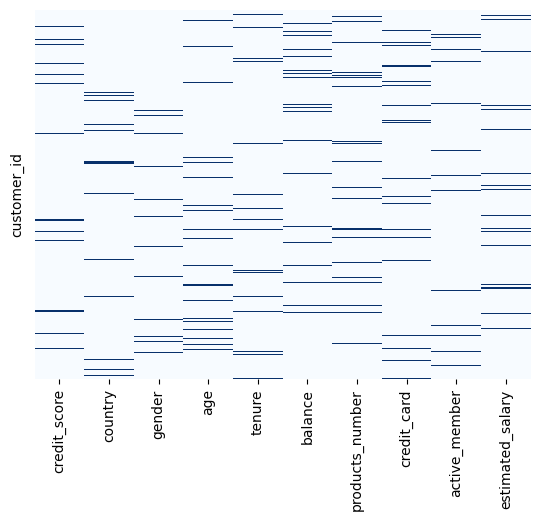

In [21]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [22]:
# Impute missing numeric values
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_numeric = numeric_imputer.fit_transform(X_train.select_dtypes(include=numerics))
X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_columns, index=X_train.index)
X_train_numeric.head()

,credit_score,age,tenure,balance,products_number,estimated_salary
customer_id,,,,,,
15733705,577.000000,30.0,8.0,92472.100000,2.000000,126434.61
15580719,697.000000,23.0,10.0,0.000000,2.000000,79734.23
15613923,581.000000,43.0,4.0,302134.442224,3.301134,100236.02
15624703,550.000000,35.0,9.0,129847.750000,2.000000,197325.40
15743817,1003.144118,40.0,8.0,174126.750000,3.000000,172490.78


In [23]:
# impute missing numeric values in test dataset
X_test_numeric = numeric_imputer.transform(X_test.select_dtypes(include=numerics))
X_test_numeric = pd.DataFrame(X_test_numeric, columns=numeric_columns, index=X_test.index)
X_test_numeric.head()

,credit_score,age,tenure,balance,products_number,estimated_salary
customer_id,,,,,,
15704651,514.0,26.0,1.0,0.00,2.0,121551.930000
15736397,544.0,23.0,1.0,96471.20,1.0,35550.970000
15596405,546.0,25.0,7.0,127728.24,2.0,105570.390000
15623595,586.0,28.0,2.0,0.00,2.0,279426.726632
15605684,664.0,31.0,7.0,104158.84,1.0,134169.850000


In [24]:
# Impute missing categorical values
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_categorical = categorical_imputer.fit_transform(X_train.select_dtypes(exclude=numerics))
X_train_categorical = pd.DataFrame(X_train_categorical, columns=categorical_columns, index=X_train.index)
X_train_categorical.head()

,country,gender,credit_card,active_member
customer_id,,,,
15733705,France,Female,no,yes
15580719,France,Female,yes,yes
15613923,Spain,Female,no,yes
15624703,Germany,Male,yes,no
15743817,Germany,Male,yes,no


In [25]:
# Impute missing categorical values in test dataset
X_test_categorical = categorical_imputer.transform(X_test.select_dtypes(exclude=numerics))
X_test_categorical = pd.DataFrame(X_test_categorical, columns=categorical_columns, index=X_test.index)
X_test_categorical.head()

,country,gender,credit_card,active_member
customer_id,,,,
15704651,France,Male,no,no
15736397,France,Male,yes,no
15596405,Spain,Male,yes,yes
15623595,Spain,Female,yes,yes
15605684,France,Female,yes,no


In [26]:
# Save imputers both numerical and categorical
with open('../artifacts/numeric_imputer.pickle', 'wb') as filename:
    pickle.dump(numeric_imputer, filename)

with open('../artifacts/categorical_imputer.pickle', 'wb') as filename:
    pickle.dump(categorical_imputer, filename)

In [27]:
X_train = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15733705,577.000000,30.0,8.0,92472.100000,2.000000,126434.61,France,Female,no,yes
15580719,697.000000,23.0,10.0,0.000000,2.000000,79734.23,France,Female,yes,yes
15613923,581.000000,43.0,4.0,302134.442224,3.301134,100236.02,Spain,Female,no,yes
15624703,550.000000,35.0,9.0,129847.750000,2.000000,197325.40,Germany,Male,yes,no
15743817,1003.144118,40.0,8.0,174126.750000,3.000000,172490.78,Germany,Male,yes,no


In [28]:
X_test = pd.concat([X_test_numeric, X_test_categorical], axis=1)
X_test.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15704651,514.0,26.0,1.0,0.00,2.0,121551.930000,France,Male,no,no
15736397,544.0,23.0,1.0,96471.20,1.0,35550.970000,France,Male,yes,no
15596405,546.0,25.0,7.0,127728.24,2.0,105570.390000,Spain,Male,yes,yes
15623595,586.0,28.0,2.0,0.00,2.0,279426.726632,Spain,Female,yes,yes
15605684,664.0,31.0,7.0,104158.84,1.0,134169.850000,France,Female,yes,no


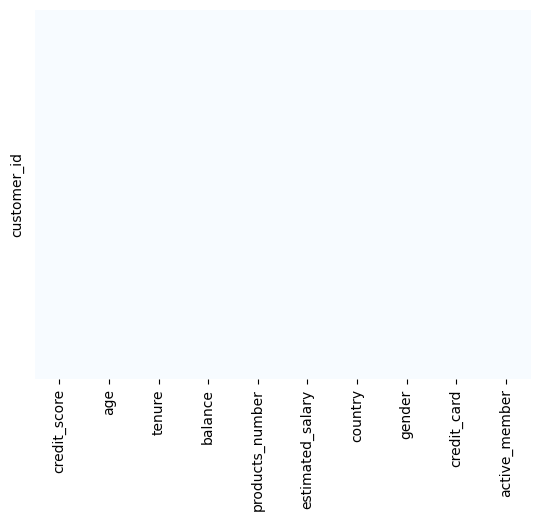

In [29]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_test.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

## Visualize Categorical Features

In [30]:
# this is important since we might have rare labels which isnt good for grouping customers; the numeric equivalent would be outliers
for category in categorical_columns:
    print('Value counts in category {}: \n{}'.format(category, X_train[category].value_counts()))

Value counts in category country: 
France     2641
Germany    1193
Spain      1166
Name: country, dtype: int64
Value counts in category gender: 
Male      2843
Female    2157
Name: gender, dtype: int64
Value counts in category credit_card: 
yes    3587
no     1413
Name: credit_card, dtype: int64
Value counts in category active_member: 
yes    2699
no     2301
Name: active_member, dtype: int64


## Encode Rare Labels

In [31]:
# encode rare labels in train data
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=10)
X_train[categorical_columns] = rare_encoder.fit_transform(X_train[categorical_columns])
X_train[categorical_columns].head()

The number of unique categories for variable country is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable gender is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable credit_card is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable active_member is less than that indicated in n_categories. Thus, all categories will be considered frequent


,country,gender,credit_card,active_member
customer_id,,,,
15733705,France,Female,no,yes
15580719,France,Female,yes,yes
15613923,Spain,Female,no,yes
15624703,Germany,Male,yes,no
15743817,Germany,Male,yes,no


In [32]:
# encode rare labels in test data
X_test[categorical_columns] = rare_encoder.transform(X_test[categorical_columns])
X_test[categorical_columns].head()

,country,gender,credit_card,active_member
customer_id,,,,
15704651,France,Male,no,no
15736397,France,Male,yes,no
15596405,Spain,Male,yes,yes
15623595,Spain,Female,yes,yes
15605684,France,Female,yes,no


In [33]:
# Save rare label encoder
with open('../artifacts/rare_encoder.pickle', 'wb') as filename:
    pickle.dump(rare_encoder, filename)

## Visualize Numerical Features

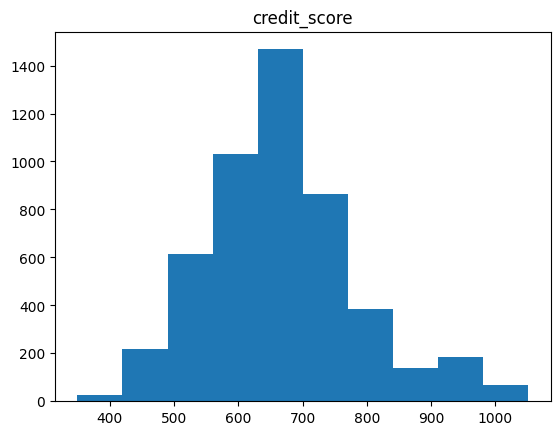

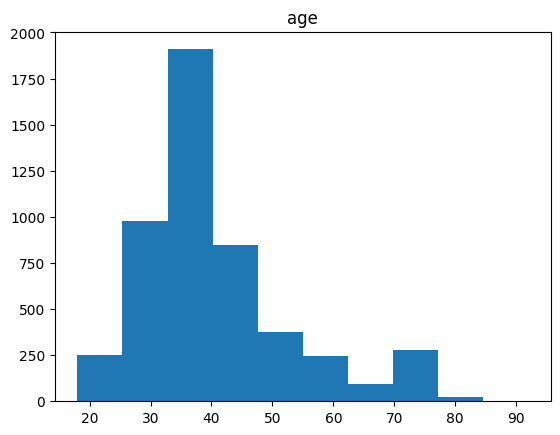

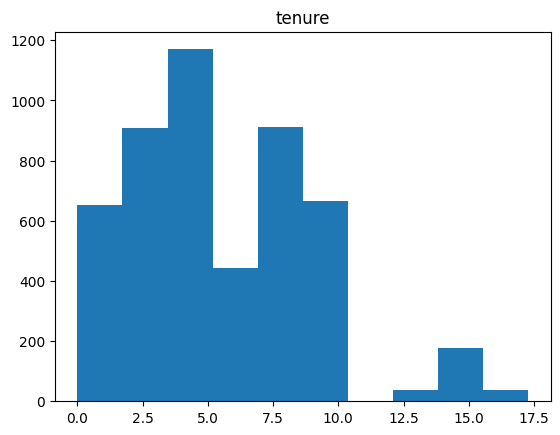

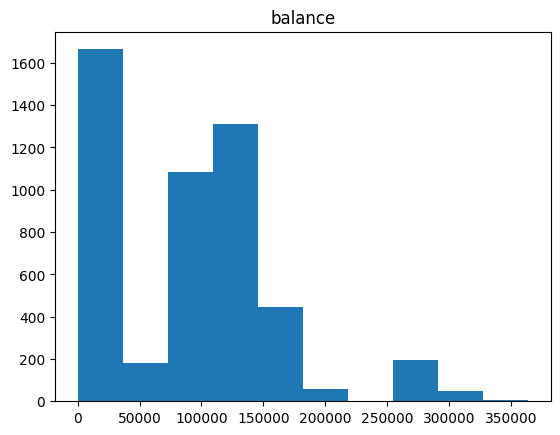

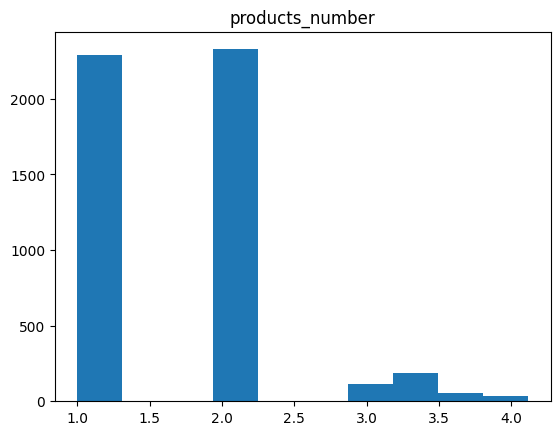

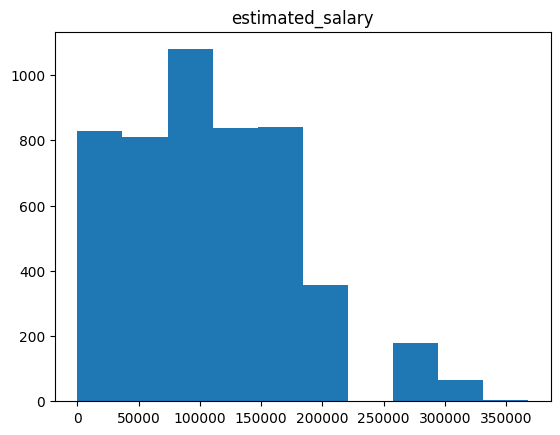

In [34]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

## Remove Outliers

In [35]:
# set up the capper
capper = Winsorizer(
    capping_method='gaussian', 
    tail='right', 
    fold=3, 
    variables=numeric_columns)

In [36]:
# fit the capper on train data
X_train[numeric_columns] = capper.fit_transform(X_train[numeric_columns])
X_train.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15733705,577.000000,30.0,8.0,92472.100000,2.000000,126434.61,France,Female,no,yes
15580719,697.000000,23.0,10.0,0.000000,2.000000,79734.23,France,Female,yes,yes
15613923,581.000000,43.0,4.0,302134.442224,3.301134,100236.02,Spain,Female,no,yes
15624703,550.000000,35.0,9.0,129847.750000,2.000000,197325.40,Germany,Male,yes,no
15743817,1003.144118,40.0,8.0,174126.750000,3.000000,172490.78,Germany,Male,yes,no


In [37]:
# fit the capper on test data
X_test[numeric_columns] = capper.transform(X_test[numeric_columns])
X_test.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15704651,514.0,26.0,1.0,0.00,2.0,121551.930000,France,Male,no,no
15736397,544.0,23.0,1.0,96471.20,1.0,35550.970000,France,Male,yes,no
15596405,546.0,25.0,7.0,127728.24,2.0,105570.390000,Spain,Male,yes,yes
15623595,586.0,28.0,2.0,0.00,2.0,279426.726632,Spain,Female,yes,yes
15605684,664.0,31.0,7.0,104158.84,1.0,134169.850000,France,Female,yes,no


In [38]:
# Save capper 
with open('../artifacts/capper.pickle', 'wb') as filename:
    pickle.dump(capper, filename)

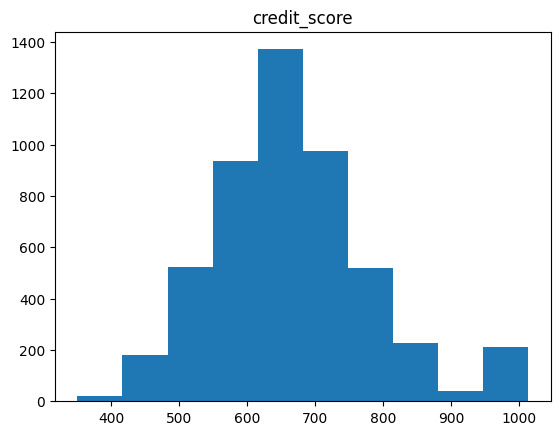

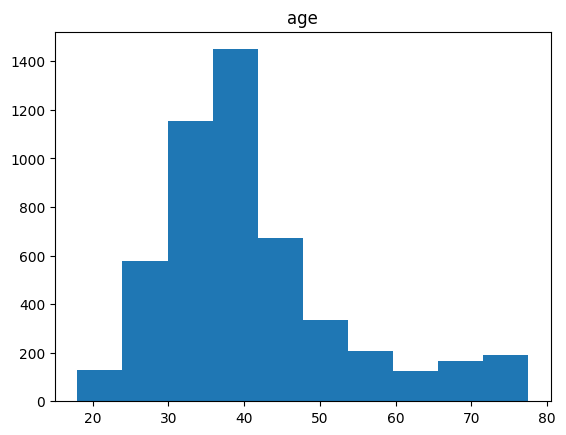

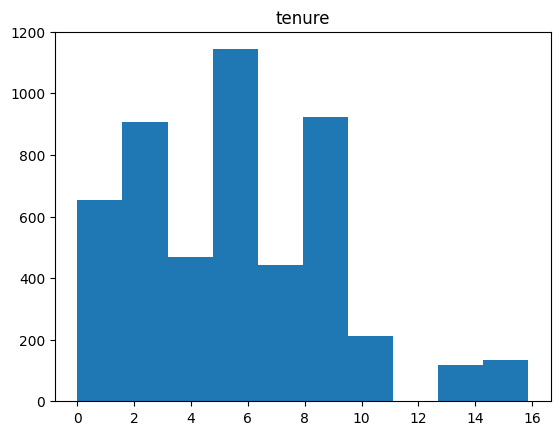

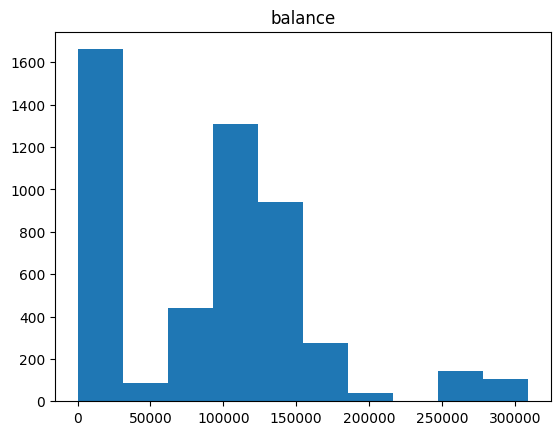

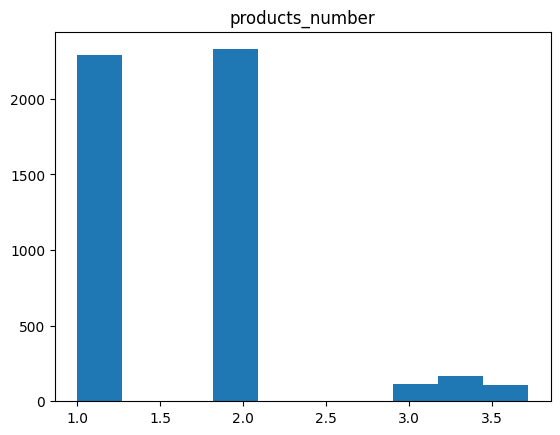

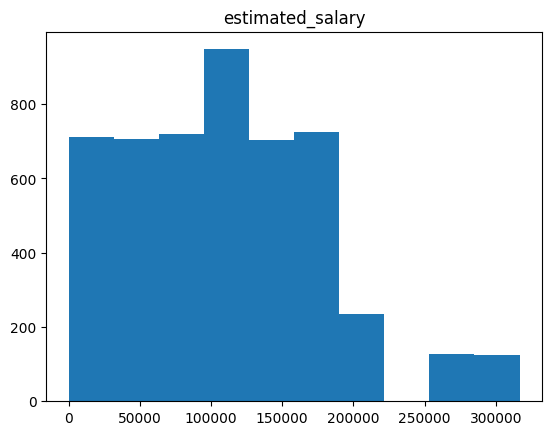

In [39]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

## One-Hote Encoding

In [40]:
enc = OneHotEncoder(
    handle_unknown='ignore',
    sparse=False,
    drop='first')

In [41]:
# hotencode train data
X_train_hot_enc = enc.fit_transform(X_train[categorical_columns])
X_train_cat_hotenc = pd.DataFrame(X_train_hot_enc, columns=enc.get_feature_names_out()) 
X_train_cat_hotenc.index = X_train.index 
X_train_hotenc = pd.concat([X_train[numeric_columns], X_train_cat_hotenc], axis=1) 
X_train_hotenc.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country_Germany,country_Spain,gender_Male,credit_card_yes,active_member_yes
customer_id,,,,,,,,,,,
15733705,577.000000,30.0,8.0,92472.100000,2.000000,126434.61,0.0,0.0,0.0,0.0,1.0
15580719,697.000000,23.0,10.0,0.000000,2.000000,79734.23,0.0,0.0,0.0,1.0,1.0
15613923,581.000000,43.0,4.0,302134.442224,3.301134,100236.02,0.0,1.0,0.0,0.0,1.0
15624703,550.000000,35.0,9.0,129847.750000,2.000000,197325.40,1.0,0.0,1.0,1.0,0.0
15743817,1003.144118,40.0,8.0,174126.750000,3.000000,172490.78,1.0,0.0,1.0,1.0,0.0


In [42]:
# hotencode test data
X_test_hot_enc = enc.transform(X_test[categorical_columns])
X_test_cat_hotenc = pd.DataFrame(X_test_hot_enc, columns=enc.get_feature_names_out()) 
X_test_cat_hotenc.index = X_test.index 
X_test_hotenc = pd.concat([X_test[numeric_columns], X_test_cat_hotenc], axis=1) 
X_test_hotenc.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country_Germany,country_Spain,gender_Male,credit_card_yes,active_member_yes
customer_id,,,,,,,,,,,
15704651,514.0,26.0,1.0,0.00,2.0,121551.930000,0.0,0.0,1.0,0.0,0.0
15736397,544.0,23.0,1.0,96471.20,1.0,35550.970000,0.0,0.0,1.0,1.0,0.0
15596405,546.0,25.0,7.0,127728.24,2.0,105570.390000,0.0,1.0,1.0,1.0,1.0
15623595,586.0,28.0,2.0,0.00,2.0,279426.726632,0.0,1.0,0.0,1.0,1.0
15605684,664.0,31.0,7.0,104158.84,1.0,134169.850000,0.0,0.0,0.0,1.0,0.0


In [43]:
# Save one hot encoder
with open('../artifacts/enc.pickle', 'wb') as filename:
    pickle.dump(enc, filename)

# Training Sklearn Random Forest

In [44]:
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=3,
    max_features='log2', 
    random_state=123)

In [45]:
rf.fit(X_train_hotenc, y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, random_state=123)

In [46]:
# evaluate accuracy on training set
rf.score(X_train_hotenc, y_train)

0.928

In [47]:
# evaluate accuracy on test set
rf.score(X_test_hotenc, y_test)

0.8424

### Tuning Random Forest

In [48]:
# parameters for Random Forest
parameters = {
    'n_estimators': (50, 100, 200, 400),
    'max_depth': (3, 5, None),
    'min_samples_split': (1, 3, 6),
    'min_samples_leaf': (1, 3, 6),
    }

model = GridSearchCV(
    rf, 
    parameters,
    scoring=make_scorer(recall_score),
    cv=3, 
    n_jobs =-1)

In [49]:
model.fit(X_train_hotenc, y_train)


108 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_features='log2',
                                              min_samples_leaf=3,
                                              min_samples_split=3,
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': (3, 5, None),
                         'min_samples_leaf': (1, 3, 6),
                         'min_samples_split': (1, 3, 6),
                         'n_estimators': (50, 100, 200, 400)},
             scoring=make_scorer(recall_score))

In [50]:
# evaluate accuracy on training set
model.score(X_train_hotenc, y_train)

0.9803729146221786

In [51]:
# evaluate accuracy on test set
model.score(X_test_hotenc, y_test)

0.36345776031434185

# Training Sklearn Gradient Boosting

In [52]:
gb = GradientBoostingClassifier(
    n_estimators=100, 
    max_depth=None,
    max_features='log2', 
    random_state=123)

In [53]:
gb.fit(X_train_hotenc, y_train)

GradientBoostingClassifier(max_depth=None, max_features='log2',
                           random_state=123)

In [54]:
# evaluate accuracy on training set
gb.score(X_train_hotenc, y_train)

1.0

In [55]:
# evaluate accuracy on test set
gb.score(X_test_hotenc, y_test)

0.839

### Tuning Gradient Boosting

In [56]:
# parameters for Gradient Boosting
parameters = {
    'n_estimators': (50, 100, 200, 400),
    'max_depth': (3, 5, None),
    }

model = GridSearchCV(
    gb, 
    parameters,
    scoring=make_scorer(recall_score),
    cv=3, 
    n_jobs =-1)

In [57]:
model.fit(X_train_hotenc, y_train)

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=None,
                                                  max_features='log2',
                                                  random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': (3, 5, None),
                         'n_estimators': (50, 100, 200, 400)},
             scoring=make_scorer(recall_score))

In [58]:
# evaluate accuracy on training set
model.score(X_train_hotenc, y_train)

0.5937193326790972

In [59]:
# evaluate accuracy on test set
model.score(X_test_hotenc, y_test)

0.431237721021611

In [60]:
model.best_params_

{'max_depth': 3, 'n_estimators': 400}

In [61]:
# Save the BEST classifier!!!
with open('../artifacts/model.pickle', 'wb') as filename:
    pickle.dump(model, filename)

# Model Evaluation

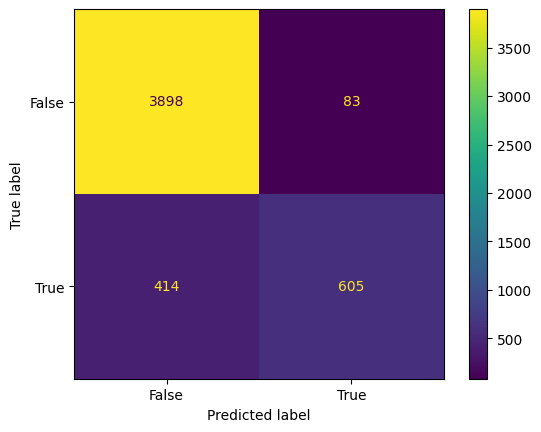

In [62]:
# plot confusion matrix for training data
plot_confusion_matrix(
    features=X_train_hotenc, 
    labels=y_train, 
    sklearn_model=model)

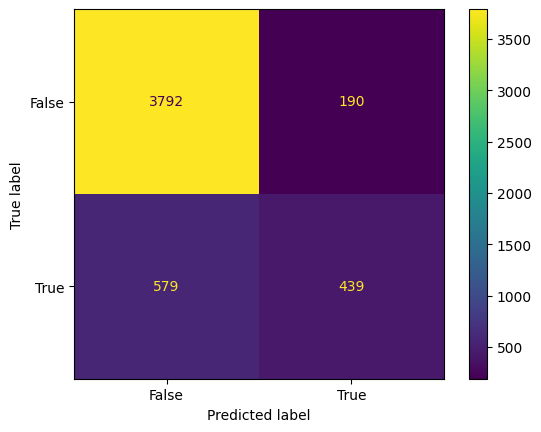

In [63]:
# plot confusion matrix for test data
plot_confusion_matrix(
    features=X_test_hotenc, 
    labels=y_test, 
    sklearn_model=model)